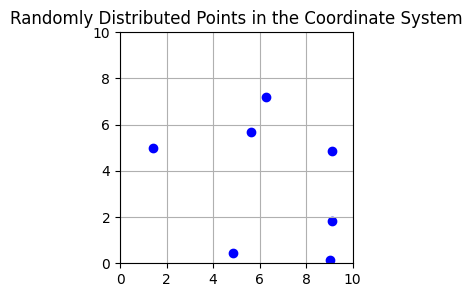

In [62]:
import numpy as np
import matplotlib.pyplot as plt

number_of_points = 7

# Generate 'count' random numbers between 0 and 1 and then scale them to the range [0, 10] for the x-axis and y-axis
def random_points(count):
    x = np.random.random(count) * 10
    y = np.random.random(count) * 10
    return x, y

x, y = random_points(number_of_points) # Generate random x and y coordinates using the function 'random_points'

plt.figure(figsize=(3, 3))  # create figure
plt.scatter(x, y, color='blue')  # scatter plot
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Randomly Distributed Points in the Coordinate System')
plt.grid(True)
plt.show()  # display plot


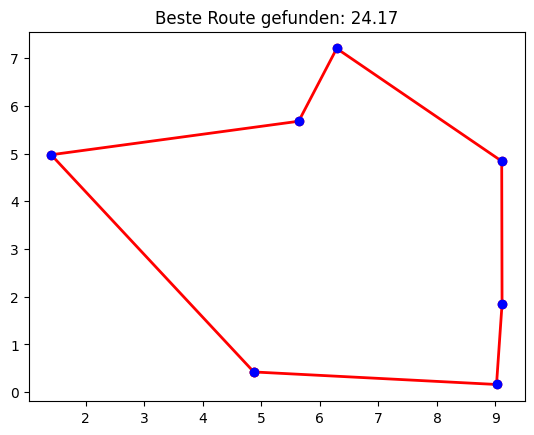

In [63]:
from itertools import permutations
import math

# Combine x and y into coordinate pairs
points = list(zip(x, y))

# Simplified distance function using math.dist.
def route_distance(route):
    d = sum(math.dist(route[i], route[i+1]) for i in range(len(route)-1))
    return d + math.dist(route[-1], route[0])  # add distance from last to first point

# Find the best route by checking all permutations
best_distance = math.inf
best_route_local = None

for route in permutations(points):
    d_current = route_distance(route)
    if d_current < best_distance:
        best_distance = d_current
        best_route_local = route

# Clear the previous plot and plot the points and best route.
plt.clf()
plt.scatter([p[0] for p in points], [p[1] for p in points], color='blue', zorder=5)
xs = [p[0] for p in best_route_local] + [best_route_local[0][0]]
ys = [p[1] for p in best_route_local] + [best_route_local[0][1]]
plt.plot(xs, ys, color='red', linewidth=2, marker='o')
plt.title(f"Beste Route gefunden: {best_distance:.2f}")
plt.show()


In [64]:
import pandas as pd

routes_list = []

# Gehe alle Permutationen der Punkte durch.
# permutations(points) erzeugt alle möglichen Anordnungen (Routen) der vorhandenen Punkte.
# enumerate() liefert neben der Route auch einen fortlaufenden Index (idx).
for idx, route in enumerate(permutations(points)):
    # Berechne die Gesamtdistanz dieser Route inklusive der Rückkehr zum Startpunkt.
    d_current = route_distance(route)
    
    # Erstelle einen formatierten String, der den Verlauf der Route beschreibt.
    # Jeder Punkt wird als "(x, y)" formatiert, wobei x und y auf 2 Dezimalstellen gerundet werden.
    # Am Ende wird der Startpunkt erneut hinzugefügt, um den Rundweg zu schließen.
    route_str = " -> ".join([f"({p[0]:.2f}, {p[1]:.2f})" for p in route] + 
                             [f"({route[0][0]:.2f}, {route[0][1]:.2f})"])
    
    # Füge ein Dictionary mit der Permutationsnummer, der formatierten Route und der berechneten Distanz der Liste hinzu.
    routes_list.append({"Permutation": idx + 1, "Route": route_str, "Distance": d_current})

# Erstelle ein pandas DataFrame aus der Liste, um die Routen übersichtlich darzustellen.
df_routes = pd.DataFrame(routes_list)

# Sortiere das DataFrame anhand der Spalte "Distance" in aufsteigender Reihenfolge,
# sodass die Route mit der minimalen Distanz an erster Stelle steht.
df_routes.sort_values("Distance", inplace=True)
# Setze den Index des DataFrames zurück, um eine fortlaufende Nummerierung zu erhalten.
df_routes.reset_index(drop=True, inplace=True)
# Gib das sortierte DataFrame aus, das alle Permutationen, die zugehörigen Routen und deren Distanzen enthält.
print(df_routes)





      Permutation                                              Route  \
0             745  (4.87, 0.42) -> (1.41, 4.97) -> (5.64, 5.68) -...   
1            1686  (6.29, 7.20) -> (5.64, 5.68) -> (1.41, 4.97) -...   
2            4227  (9.11, 1.85) -> (9.02, 0.16) -> (4.87, 0.42) -...   
3            1893  (6.29, 7.20) -> (9.11, 4.84) -> (9.11, 1.85) -...   
4            4447  (9.02, 0.16) -> (4.87, 0.42) -> (1.41, 4.97) -...   
...           ...                                                ...   
5035          549  (1.41, 4.97) -> (9.11, 1.85) -> (5.64, 5.68) -...   
5036         2653  (5.64, 5.68) -> (9.11, 1.85) -> (1.41, 4.97) -...   
5037          947  (4.87, 0.42) -> (6.29, 7.20) -> (9.02, 0.16) -...   
5038         3046  (9.11, 4.84) -> (4.87, 0.42) -> (6.29, 7.20) -...   
5039         4072  (9.11, 1.85) -> (5.64, 5.68) -> (9.02, 0.16) -...   

       Distance  
0     24.173231  
1     24.173231  
2     24.173231  
3     24.173231  
4     24.173231  
...         ...  
5035  48.